# XAI Tutorial 1: Label Tracking

## Overview
In this tutorial, we will discuss the following topics:
* [Label Tracking](#tx01labels)

We'll start by getting the imports out of the way:

In [1]:
import tempfile
import os

import fastestimator as fe
from fastestimator.architecture.tensorflow import LeNet
from fastestimator.backend import squeeze, reduce_mean
from fastestimator.dataset.data import cifair10
from fastestimator.op.numpyop.meta import Sometimes
from fastestimator.op.numpyop.multivariate import HorizontalFlip, PadIfNeeded, RandomCrop
from fastestimator.op.numpyop.univariate import CoarseDropout, Normalize
from fastestimator.op.tensorop.loss import CrossEntropy
from fastestimator.op.tensorop.model import ModelOp, UpdateOp
from fastestimator.op.tensorop import LambdaOp
from fastestimator.schedule import RepeatScheduler
from fastestimator.trace.adapt import LRScheduler
from fastestimator.trace.io import BestModelSaver, ImageViewer, TensorBoard
from fastestimator.trace.metric import MCC
from fastestimator.trace.xai import LabelTracker
from fastestimator.util import to_number

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization

import matplotlib.pyplot as plt
import numpy as np

label_mapping = {
    'airplane': 0,
    'automobile': 1,
    'bird': 2,
    'cat': 3,
    'deer': 4,
    'dog': 5,
    'frog': 6,
    'horse': 7,
    'ship': 8,
    'truck': 9
}

<a id='tx01labels'></a>

## Label Tracking

Suppose you are doing some training, and you want to know whether a particular class is easier or harder than other classes for your network to learn. One way to investigate this is with the `LabelTracker` `Trace`. It takes as input any per-element metric (such as sample-wise loss), as well as any label vector (usually class labels, but it could be any grouping) and produces a visualization at the end of training:

In [2]:
batch_size=128
save_dir = tempfile.mkdtemp()

train_data, eval_data = cifair10.load_data()
test_data = eval_data.split(range(len(eval_data) // 2))
pipeline = fe.Pipeline(
    train_data=train_data,
    eval_data=eval_data,
    test_data=test_data,
    batch_size=batch_size,
    ops=[Normalize(inputs="x", outputs="x", mean=(0.4914, 0.4822, 0.4465), std=(0.2471, 0.2435, 0.2616)),
         PadIfNeeded(min_height=40, min_width=40, image_in="x", image_out="x", mode="train"),
         RandomCrop(32, 32, image_in="x", image_out="x", mode="train"),
         Sometimes(HorizontalFlip(image_in="x", image_out="x", mode="train")),
         CoarseDropout(inputs="x", outputs="x", mode="train", max_holes=1),
         ],
    num_process=0)

model = fe.build(model_fn=lambda: LeNet(input_shape=(32, 32, 3)), optimizer_fn="adam")
network = fe.Network(ops=[
    ModelOp(model=model, inputs="x", outputs="y_pred"),
    CrossEntropy(inputs=("y_pred", "y"), outputs="ce", mode="train"),
    CrossEntropy(inputs=("y_pred", "y"), outputs="sample_ce", mode=("eval", "test"), average_loss=False),
    LambdaOp(inputs="sample_ce", outputs="ce", mode=("eval", "test"), fn=lambda x: reduce_mean(x)),
    UpdateOp(model=model, loss_name="ce")
])

traces = [
    MCC(true_key="y", pred_key="y_pred"),
    BestModelSaver(model=model, save_dir=save_dir, metric="mcc", save_best_mode="max", load_best_final=True),
    LabelTracker(label="y", metric="sample_ce", label_mapping=label_mapping, outputs="ce_vs_y", bounds=None, mode=["eval", "test"]),
    ImageViewer(inputs="ce_vs_y", mode=["eval", "test"])
]
estimator = fe.Estimator(pipeline=pipeline,
                         network=network,
                         epochs=10,
                         traces=traces,
                         log_steps=300)

    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        

FastEstimator-Start: step: 1; logging_interval: 300; num_device: 0;
FastEstimator-Train: step: 1; ce: 2.32721;
FastEstimator-Train: step: 300; ce: 1.338028; steps/sec: 14.89;
FastEstimator-Train: step: 391; epoch: 1; epoch_time: 27.9 sec;
FastEstimator-BestModelSaver: Saved model to /var/folders/3r/h9kh47050gv6rbt_pgf8cl540000gn/T/tmpdcv5kfby/model_best_mcc.h5
FastEstimator-Eval: step: 391; epoch: 1; ce: 1.2785366; max_mcc: 0.48404556307705315; mcc: 0.48404556307705315; since_best_mcc: 0;
FastEstimator-Train: step: 600; ce: 1.2232394; steps/sec: 14.02;
Fa

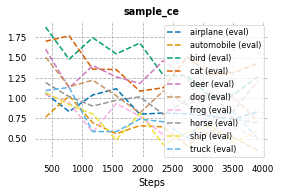

FastEstimator-Finish: step: 3910; model_lr: 0.001; total_time: 329.01 sec;


In [3]:
estimator.fit()

From the graph above it seems that cats are relatively difficult for the network to learn well, whereas automobiles are pretty easy.